In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pymlx import *
import time

Load data

In [3]:
train_file = '../data/census_income.train.csv'
test_file = '../data/census_income.test.csv'
label_col = 'Income >50K'

train_df, _ = utils.load_data(train_file, label_col)
# suggested_handlers = suggest_handlers(train_df)

feat = Featurizer([
    OneHotHandler(['Native Country', 'Occupation', 'Race', 'Relationship Status', 'Sex', 'Workclass']),
    BinNormalizer(['Age', 'Capital Gain', 'Hours per week', 'Years in Education', 'Capital Loss']),
    IdEncodingHandler(['Education', 'Marital Status'])
])

Learn features

In [4]:
start_timing()
feat.learn(train_file) # in case the train data is large, the featurizer only needs to be trained on sampled data
train_features, train_labels = utils.load_featurized_data(train_file, label_col, feat, return_dataframe=True)
report_timing()

Elapsed: 0.054 minutes


Find the best params

In [6]:
import xgboost
import lightgbm

In [8]:
start_timing()
sweeper = random_sweep(
    train_features, train_labels, 
    lightgbm.LGBMClassifier(), {
                      'max_depth': [3, 5, 10, 20], 
                      'n_estimators': [10, 20, 40, 80],
                      'subsample': [1, 0.8]},
    scoring=pr_scorer, n_iter=10, verbose=1)
report_timing()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Elapsed: 0.09 minutes


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.4s finished


In [9]:
sweep_stats(sweeper)

/home/haiit/anaconda2/envs/pymlx/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,Score,Std,max_depth,n_estimators,subsample
0,0.816136,0.006774,5,80,1.0
1,0.805283,0.007858,5,40,1.0
2,0.803802,0.006881,10,20,0.8
3,0.803707,0.008138,20,20,0.8
4,0.803707,0.008138,20,20,1.0
5,0.792588,0.008355,5,20,0.8
6,0.790764,0.007289,20,10,0.8
7,0.771909,0.009652,3,20,1.0
8,0.771909,0.009652,3,20,0.8
9,0.754068,0.010357,3,10,1.0


Training

In [10]:
start_timing()
predictor = lightgbm.LGBMClassifier(n_estimators=80, max_depth=5, subsample=1)
predictor.fit(train_features, train_labels) # refit the model on full data
report_timing()

# Combine featurizer and predictor to make an end-to-end model
model = BinaryClassifier(predictor, feat)

Elapsed: 0.0032 minutes


Testing

In [12]:
test_df, test_labels = load_data(test_file, label_col)

In [13]:
predictions, raw = model.bulk_predict(test_df)

Result

In [14]:
confusion_matrix(test_labels, predictions)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

Feature importance

In [15]:
fscores = model.get_fscores()
fscores.head(10)

Age_bin                        349
Capital_Gain_bin               256
Hours_per_week_bin             247
Years_in_Education_bin         213
Capital_Loss_bin               170
Marital_Status_ide             105
Education_ide                   88
Relationship_Status=Wife        57
Relationship_Status=Husband     50
Workclass=Self-emp-not-inc      42
dtype: int64

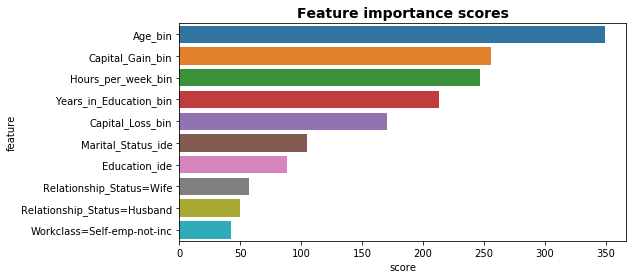

In [18]:
visualize_feature_importance(fscores.to_dict(), 10, fig_height=4)

Feature density to the target

In [23]:
features = train_features.copy()
features['Target'] = train_labels

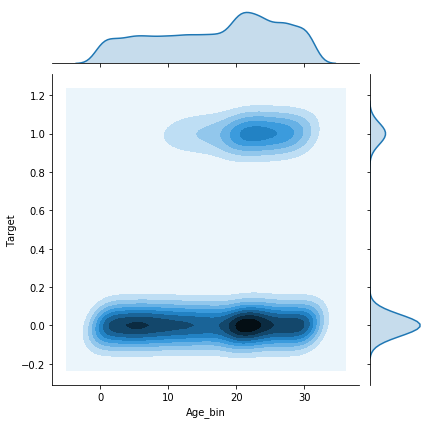

In [24]:
visualize_feat_density(features, 'Age_bin', 'Target')